## Imports

In [1]:
using Distributions: Beta, pdf
using Plots

## Slot Machine

In [2]:
mutable struct SlotMachine
    reward::Float64
end

In [3]:
function SlotMachine_pull_arm(slot_machine::SlotMachine)
    slot_machine.reward
end

SlotMachine_pull_arm (generic function with 1 method)

## Slot Machine Hat

In [4]:
mutable struct SlotMachineHat
    α::Float64
    β::Float64
end

In [5]:
function SlotMachineHat_update(slot_machine_hat::SlotMachineHat, r::Float64)
    slot_machine_hat.α += r
    slot_machine_hat.β += (1-r)
    slot_machine_hat
end

SlotMachineHat_update (generic function with 1 method)

In [6]:
function SlotMachineHat_distr(slot_machine_hat::SlotMachineHat)
    Beta(slot_machine_hat.α, slot_machine_hat.β)
end

SlotMachineHat_distr (generic function with 1 method)

In [7]:
function SlotMachineHat_pull_arm(slot_machine_hat::SlotMachineHat)
    rand(SlotMachineHat_distr(slot_machine_hat))
end

SlotMachineHat_pull_arm (generic function with 1 method)

In [8]:
function SlotMachineHat_copy(slot_machine_hat::SlotMachineHat)
    SlotMachineHat(copy(slot_machine_hat.α), copy(slot_machine_hat.β))
end

SlotMachineHat_copy (generic function with 1 method)

In [9]:
function SlotMachineHat_pdf(slot_machine_hat::SlotMachineHat, x::Vector{Float64})
    pdf.(SlotMachineHat_distr(slot_machine_hat), x)
end

SlotMachineHat_pdf (generic function with 1 method)

## BanditThompson

In [10]:
mutable struct BanditThompson
    K::Int64
    slot_machines::Vector{SlotMachine}
    slot_machines_hats_tracking::Vector{Vector{SlotMachineHat}}
    decision_tracking::Vector{Int64}
    reward_tracking::Vector{Float64}
end

In [11]:
function BanditThompson_init(slot_machines::Vector{SlotMachine}; α::Float64=1.0, β::Float64=1.0)
    K = size(slot_machines, 1)
    slot_machines_hats = SlotMachineHat[]
    for k=1:K
        push!(slot_machines_hats, SlotMachineHat(α,β))
    end
    slot_machines_hats_tracking = [slot_machines_hats]
    BanditThompson(K, slot_machines, slot_machines_hats_tracking, [], [])
end

BanditThompson_init (generic function with 1 method)

In [12]:
function BanditThompson_rewards_hats_(bandit::BanditThompson)
    rewards_hats       = zeros(Float64, 10)
    slot_machines_hats = bandit.slot_machines_hats_tracking[end]
    for k=1:bandit.K
        slot_machine_hat = slot_machines_hats[k]
        reward_hat       = SlotMachineHat_pull_arm(slot_machine_hat)
        rewards_hats[k]  = reward_hat
    end
    rewards_hats
end

BanditThompson_rewards_hats_ (generic function with 1 method)

In [13]:
function BanditThompson_select_slot_machine_(bandit::BanditThompson, rewards_hat::Vector{Float64})
    max_reward_hat, max_k_hat = findmax(rewards_hat)
    max_k_hat
end

BanditThompson_select_slot_machine_ (generic function with 1 method)

In [14]:
function BanditThompson_pull_arm_(bandit::BanditThompson, k::Int64)
    SlotMachine_pull_arm(bandit.slot_machines[k])
end

BanditThompson_pull_arm_ (generic function with 1 method)

In [15]:
function BanditThompson_update_(bandit::BanditThompson, k::Int64, reward::Float64)
    current_slot_machines_hats = bandit.slot_machines_hats_tracking[end]
    new_slot_machines_hats = SlotMachineHat[]
    for k=1:bandit.K
        current_slot_machine_hat = current_slot_machines_hats[k]
        new_slot_machine_hat     = SlotMachineHat_copy(current_slot_machine_hat)
        push!(new_slot_machines_hats, new_slot_machine_hat)
    end
    SlotMachineHat_update(new_slot_machines_hats[k], reward)
    push!(bandit.slot_machines_hats_tracking, new_slot_machines_hats)
    push!(bandit.decision_tracking, k)
    push!(bandit.reward_tracking, reward)
end

BanditThompson_update_ (generic function with 1 method)

In [16]:
function BanditThompson_pull_arm(bandit::BanditThompson)
    rewards_hat = BanditThompson_rewards_hats_(bandit)
    max_k_hat   = BanditThompson_select_slot_machine_(bandit, rewards_hat)
    reward      = BanditThompson_pull_arm_(bandit, max_k_hat)
    BanditThompson_update_(bandit, max_k_hat, reward)
    bandit
end

BanditThompson_pull_arm (generic function with 1 method)

In [17]:
function BanditThompson_plot_pdf(bandit::BanditThompson; t::Int64 = -1)
    t = (t == -1) ? size(bandit.slot_machines_hats_tracking, 1) : t
    x = collect(range(0, 1, 100))
    slot_machines_hats = bandit.slot_machines_hats_tracking[t]
    p = plot(title="Bandit Thompson's Slot Machines Hat PDFs [Track $(t)]", xlabel="Mean reward", ylabel="Probability density")
    for (k, slot_machine) in enumerate(slot_machines_hats)
        plot!(x, SlotMachineHat_pdf(slot_machine, x), label="k=$(k)")
    end
    p
end

BanditThompson_plot_pdf (generic function with 1 method)

## Simulations

In [18]:
slot_machines = [SlotMachine(0.9), SlotMachine(0.8), SlotMachine(0.7)]
bandit        = BanditThompson_init(slot_machines)

T = 1000
for t=1:T
    BanditThompson_pull_arm(bandit)
end

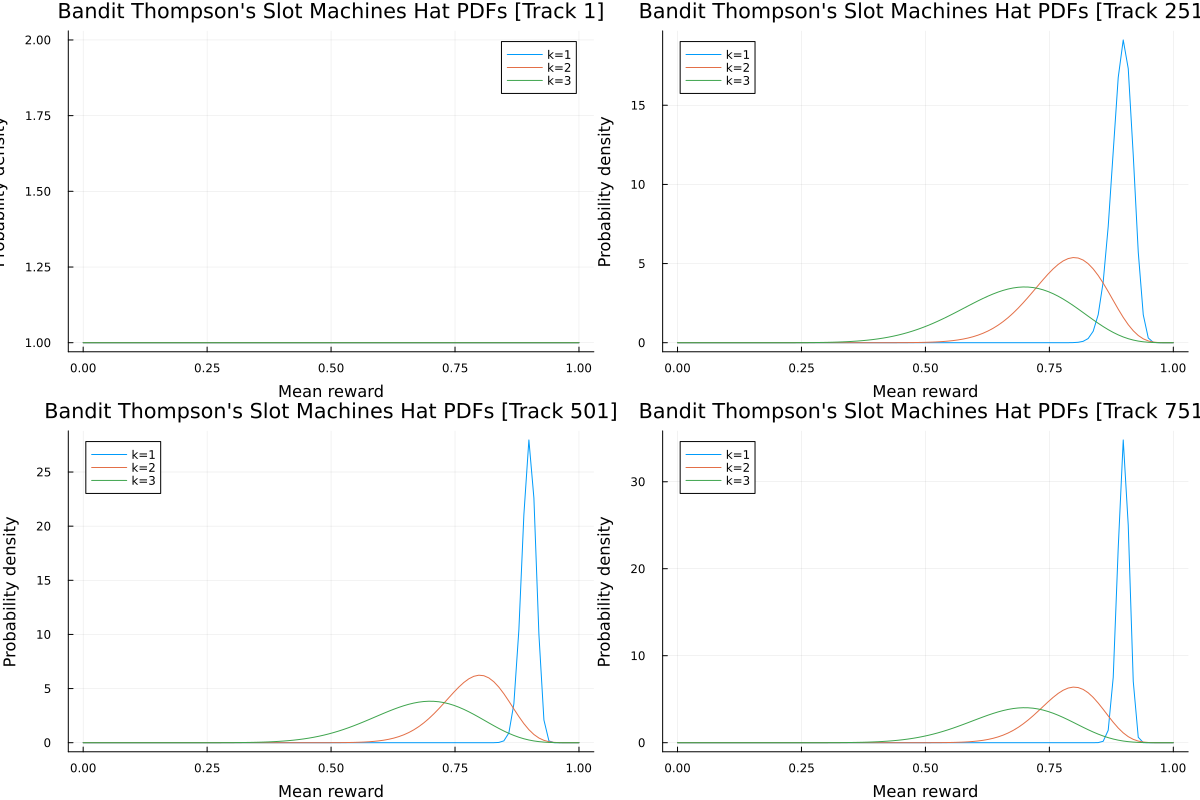

In [35]:
pdf_plots = []
for t=1:250:T
    push!(pdf_plots, BanditThompson_plot_pdf(bandit; t=t))
end
plot(pdf_plots..., layout=(2,2), size=(1200, 800))

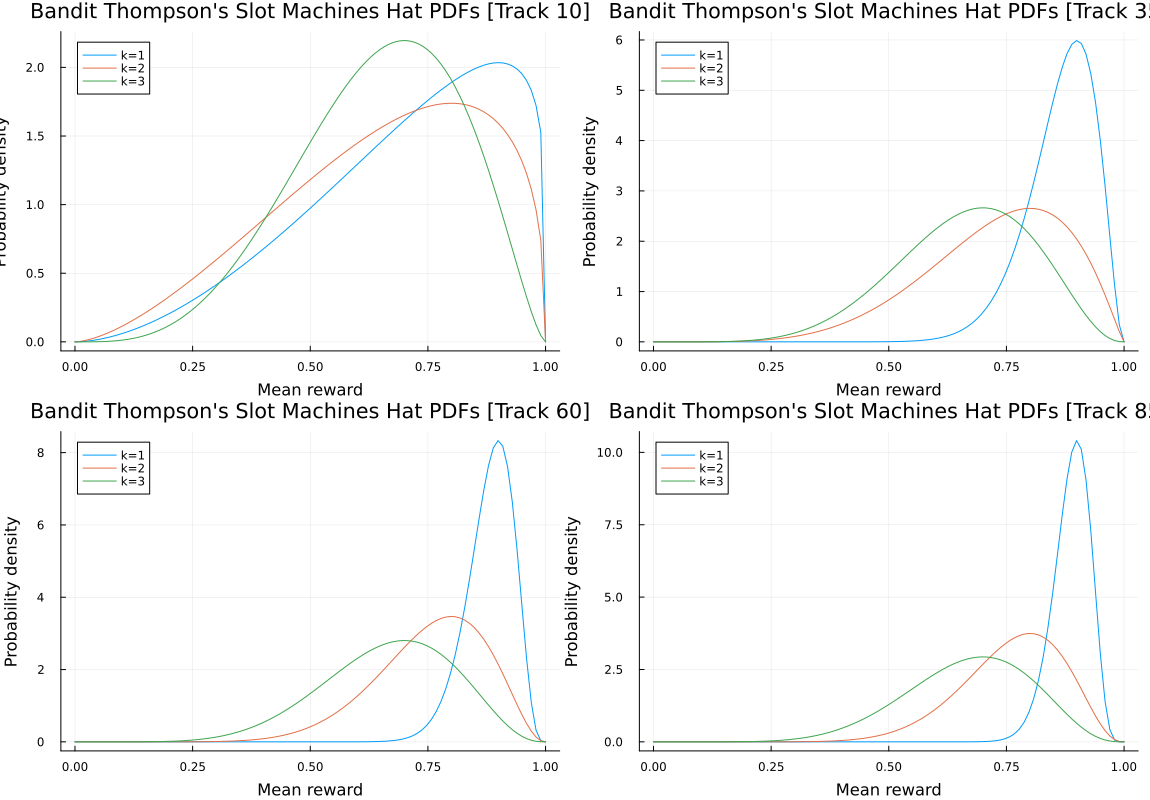

In [43]:
pdf_plots = []
for t=10:25:100
    push!(pdf_plots, BanditThompson_plot_pdf(bandit; t=t))
end
plot(pdf_plots..., layout=(2,2), size=(1150, 800))